<a href="https://colab.research.google.com/github/yongtaoliu/MHP_GB_by_ResHedNet/blob/main/Paper_MHP_ResHedNet_IV_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook--Plot ResHedNet cAFM IV results:

Sep 2022

*   By [Yongtao Liu](https://scholar.google.com/citations?user=V9FMPgQAAAAJ&hl=en) (Funding: EFRC Award Number DE-SC0021118)

# Download and Imports:

In [1]:
!pip install -q atomai==0.3.5
!pip install pycroscopy
!pip install sidpy

     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 26.5 MB 1.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 2.7 MB/s 
     |████████████████████████████████| 96 kB 5.3 MB/s 
     |████████████████████████████████| 66 kB 5.4 MB/s 
     |████████████████████████████████| 198 kB 65.1 MB/s 
     |████████████████████████████████| 1.6 MB 55.6 MB/s 
     |████████████████████████████████| 1.6 MB 59.7 MB/s 
     |████████████████████████████████| 154 kB 67.8 MB/s 
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=22871744b8e012a4fa3099d853e497c79f1d8b2f136876f67e615d173bfa9006
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from typing import Union, Tuple, List, Type, Optional

import math
import matplotlib.pyplot as plt
import numpy as np
from atomai import utils

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
import h5py
import sidpy

# Help Function

In [3]:
#helper function
def pix_to_xy(pixind, num_cols):
    col = int(pixind % (num_cols))
    row =int(np.floor(pixind/ num_cols))
    return row, col

def xy_to_pixind(row,col,num_cols):
    return row*num_cols + col

def det_phase_offset(phase_mat_lin):
    """Input:
        - phase mat: numpy vector of size N, containing the phase values of every point
    Output:
        - phase_offset: float of the phase offset requried to center the phase
        Here centering means that one side will be 0 and the other will be pi, 
        so the loop can be projected as A*cos(phi)"""

    #First calculate the histogram of the phase values
    
    num_bins = 150 #number of bins in histogram
    hist, bin_edges = np.histogram(phase_mat_lin, bins = num_bins)
    
    #Remove zero values. Sometimes, when phase is undefined the zero bin will have a peak. Remove this,
    #and replace it with the average of the two surrounding bins on either side
    hist[num_bins//2-5:num_bins//2+5] = 0.5*(hist[num_bins//2-5] + hist[num_bins//2+5])
    
    #Now find the two peaks by finding the two relative maxima

    peak_positions = find_peaks(hist, distance = num_bins//3)

    phase_1 = bin_edges[peak_positions[0][0]]
    phase_2 = bin_edges[peak_positions[0][1]]

    print ('The phase difference is {}'.format(np.round(np.abs(phase_1 - phase_2),3)))
    print ('The phase offset is {}'.format(np.round(phase_1,3)))

    if np.abs(np.abs(phase_1 - phase_2) - np.pi) >0.5:
        print('There was a problem with automatic phase offset determination! Do it manually before proceeding!!')
    phase_offset = phase_1
    
    return phase_offset

def usid_to_pr(h5_f, sho_fit_group = None):
    
    """This function takes as an input a h5 path to a USID file for a BEPS measurement, 
    and then returns a piezoresponse matrix along with the voltage vector for the first cycle
    Inputs:
    h5_path: string - path to the usid file containing the BEPS measurement

    Output:
    pr_array: numpy ndarray - numpy array containing the piezoresponse matrix in 3D form
    vdc_vec: numpy ndarray - numpy array containing the voltage vector

    """
    #h5_f = h5py.File(h5_path, 'r')
    if sho_fit_group is None:
        
        sho_mat = h5_f['Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Guess']
        spec_val = h5_f['Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values']
        pos_inds = h5_f['Measurement_000/Channel_000/Position_Indices']

    else:
        sho_mat = sho_fit_group['Fit']
        spec_val = sho_fit_group['Spectroscopic_Values']
        pos_inds = sho_fit_group.parent['Position_Indices']
        
    pos_dim_sizes = [np.max(pos_inds[:,0])+1, np.max(pos_inds[:,1]+1)]


    #Extract the amplitude and phase from the guess or fit
    sho_mat_ndim = sho_mat[:].reshape(pos_dim_sizes[0], pos_dim_sizes[1], -1)
    amp_mat_ndim = sho_mat_ndim['Amplitude [V]']
    
    points_measured = sho_mat['Quality Factor'][:,1]!=0
    points_measured = np.where(points_measured==True)[0]
    
    phase_mat_ndim = sho_mat_ndim['Phase [rad]']
    phase_mat = sho_mat['Phase [rad]']

    #First calculate phase offset
    
    #Be careful for this: we need to exclude points that have not been measured!
    phase_mat_ndim_measured = phase_mat.copy()[points_measured,:]
    phase_offset = 0

    pr_mat_ndim_real_all = (amp_mat_ndim*np.cos(phase_mat_ndim-phase_offset))
    pr_mat_ndim_imag_all = (amp_mat_ndim*np.sin(phase_mat_ndim-phase_offset))
    
    pr_mat_ndim_real = np.zeros((128,128,256))
    pr_mat_ndim_imag = np.zeros((128,128,256))

    vdc = spec_val[0,:]
    
    h5_f.close()

    return [pr_mat_ndim_real, pr_mat_ndim_imag], vdc, points_measured

def turn_on_voltage(y_iv, x_vdc):
  y = y_iv[:int(len(y_iv)/2)]
  x = x_vdc[:int(len(x_vdc)/2)]
  yhat = savgol_filter(y, 55, 5)
  der = np.gradient(yhat, x)

  idx = np.where(der>0.0015)

  if len(idx[0])==0:
    v_turn_on = -1.6
  else:
    v_turn_on = x[idx[0][0]]
  
  return v_turn_on

def hysteresis(y_iv):
  y1 = y_iv[:int(len(y_iv)/2)]
  y2 = y_iv[int(len(y_iv)/2):]

  hy = abs(y2.mean()-y1.mean())
    
  return hy*1e4

def area_x(y_iv):
  y1 = y_iv[:int(len(y_iv)/2)]
  y = y_iv[int(len(y_iv)/2)]
  area_ = -y*1.5*100
    
  return area_

(Down)load and preprocess data ⬇️ 📜

In [4]:
#download Topo image data and IV spectra data

!gdown -q https://drive.google.com/uc?id=1IuMZM484fWpOLEiJKkRqfDexS2GtJG_n
!gdown -q https://drive.google.com/uc?id=1IuwyRlJcNht6tFOHKr1A7btDZk-uAE-I

In [5]:
boundary = np.load("ResHedNet_MHP_Grain_Boundary.npz")
grain = np.load("ResHedNet_MHP_Grain.npz")

In [6]:
v_step = grain['v_step']

iv_light_grain = grain["iv_light_grain"]
iv_dark_grain = grain['iv_dark_grain']
grain_idx_x = grain['measured_idx_x']
grain_idx_y = grain['measured_idx_y']

iv_light_gb = boundary['iv_light_boundary']
iv_dark_gb = boundary['iv_dark_boundary']
gb_idx_x = boundary['measured_idx_x']
gb_idx_y = boundary['measured_idx_y']

(-0.5, 127.5, -0.5, 127.5)

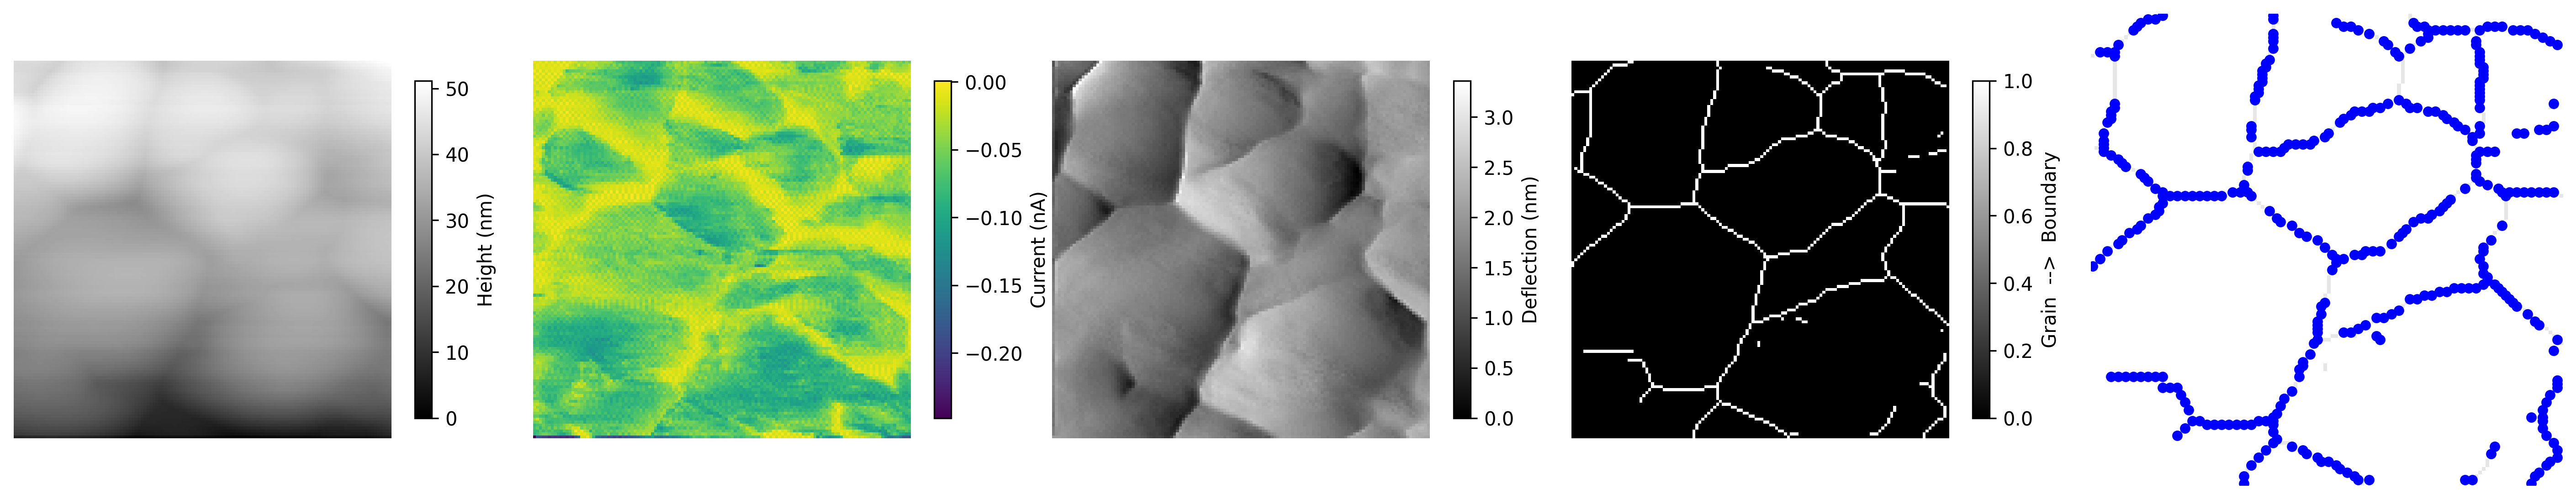

In [7]:
topo = boundary['topo_map']
cmap = boundary['cur_map'] 
defl = boundary['defl_map']
bd_map = boundary['grain_boundary_map']

fig, axs = plt.subplots(1, 5, figsize=(20, 4), dpi =300)
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.1)
# Make 4 subplots:
cm = 'viridis'
shrink = 0.7

im1 = axs[0].imshow((topo-topo.min())*100, interpolation='nearest', origin = "lower", cmap='gray')
fig.colorbar(im1, ax=axs[0], shrink = shrink, label = "Height (nm)")
axs[0].axis('off')

im2 = axs[1].imshow(cmap*1e2, interpolation='nearest', origin = "lower", cmap=cm)
fig.colorbar(im2, ax=axs[1], shrink = shrink, label = "Current (nA)")
axs[1].axis('off')

im3 = axs[2].imshow((defl-defl.min())*100, interpolation='nearest', origin = "lower", cmap='gray')
fig.colorbar(im3, ax=axs[2], shrink = shrink, label = "Deflection (nm)")
axs[2].axis('off')

im4 = axs[3].imshow(bd_map, interpolation='nearest', origin = "lower", cmap = 'gray')
fig.colorbar(im4, ax=axs[3], shrink = shrink, label = "Grain  -->  Boundary")
axs[3].axis('off')

im5 = axs[4].imshow(bd_map, interpolation='nearest', origin = "lower", cmap = 'binary', vmax=10)
#fig.colorbar(im5, ax=axs[4], shrink = shrink)
axs[4].scatter(gb_idx_x, gb_idx_y, c = 'blue', s =20)
axs[4].axis('off')

(-0.5, 127.5, 127.5, -0.5)

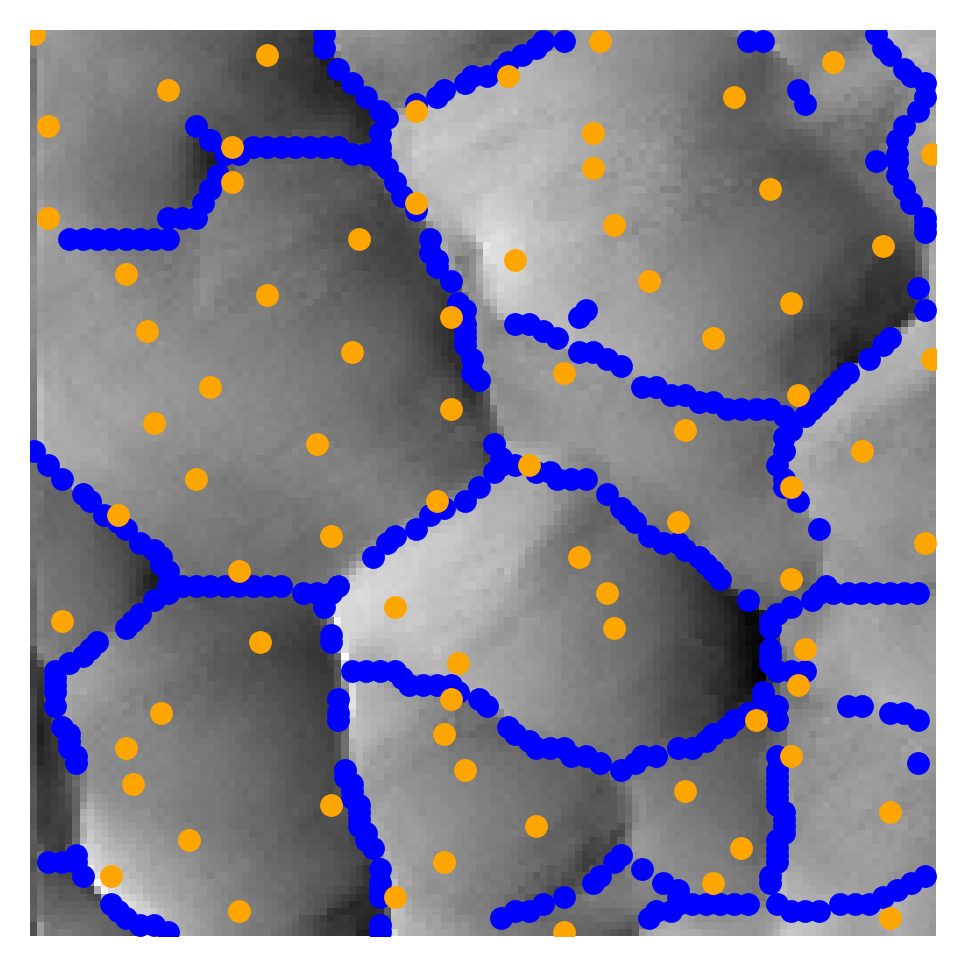

In [8]:
f, ax1 = plt.subplots(figsize = (4, 4), dpi = 300)
ax1.imshow(defl, cmap = 'gray')
ax1.scatter(gb_idx_x, gb_idx_y, s =20, c = 'blue')
ax1.scatter(grain_idx_x, grain_idx_y, s =20, c = 'orange')
ax1.axis('off')

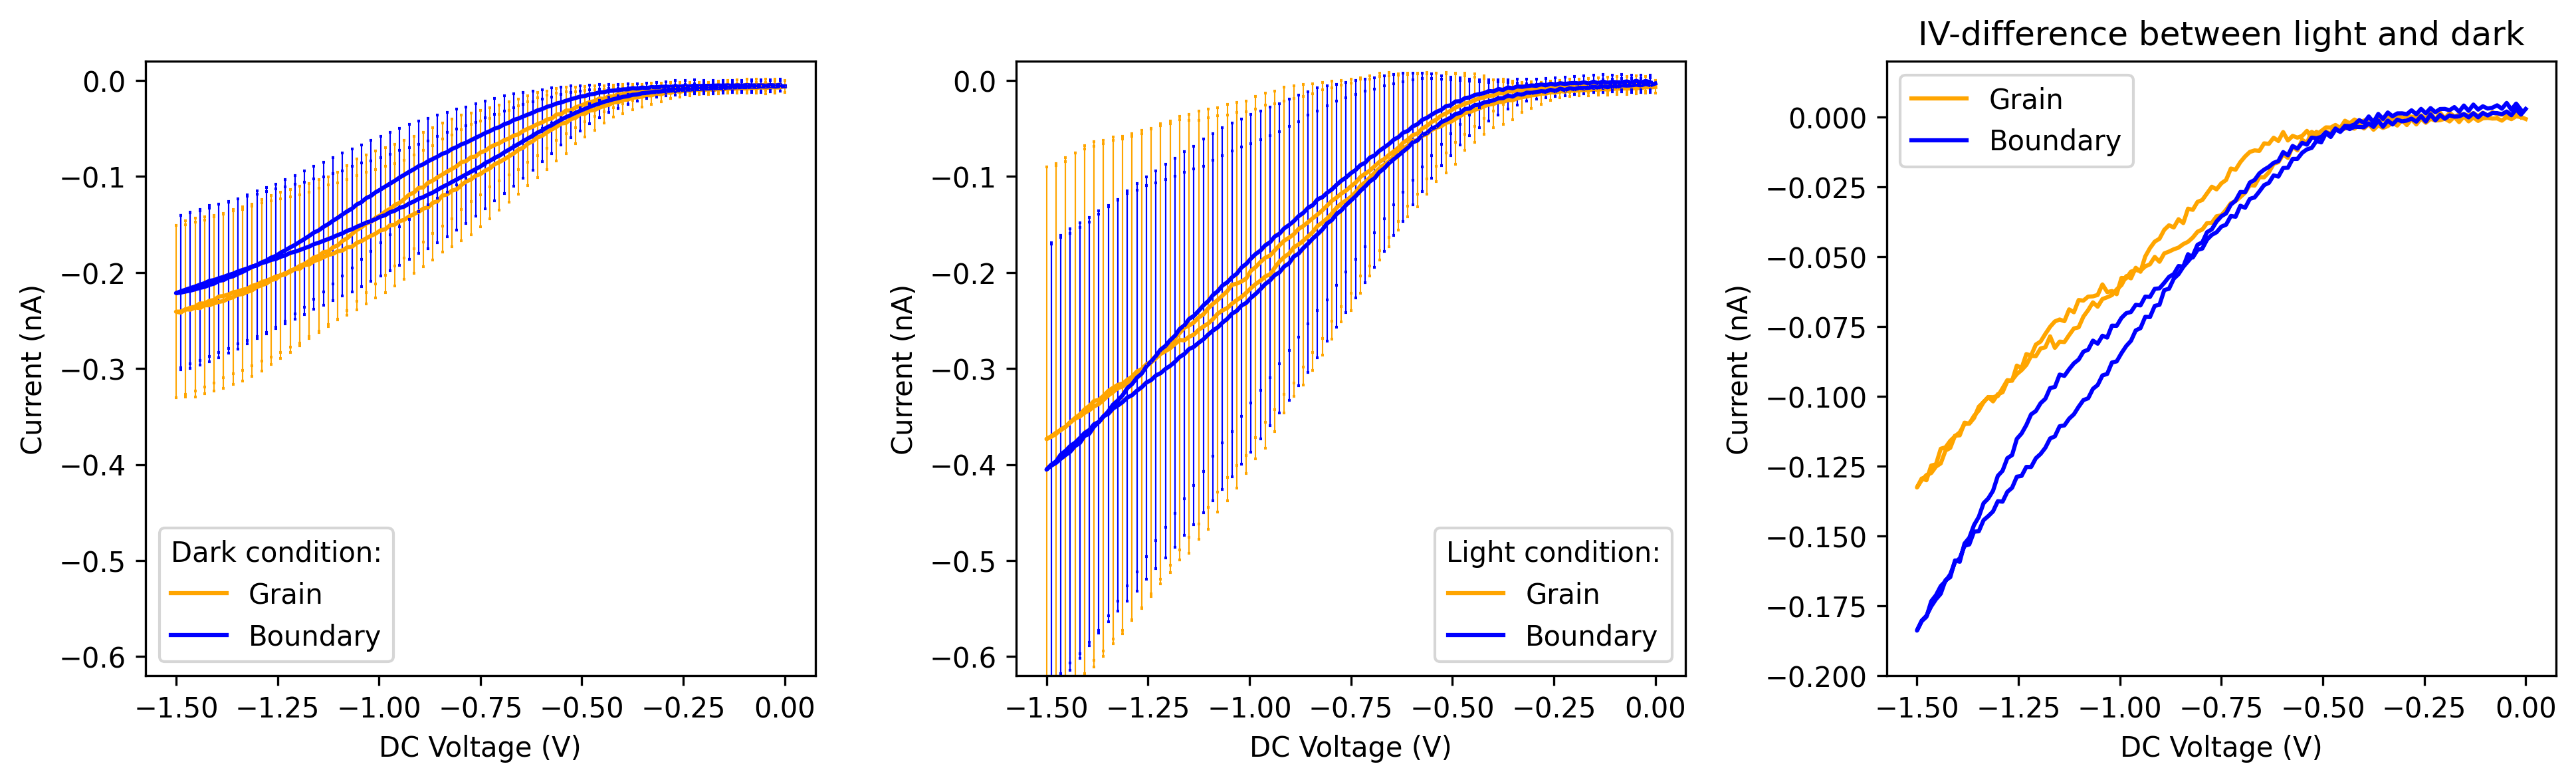

In [9]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (13, 3.5), dpi = 300)
f.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.3)

ax1.plot(v_step, (iv_dark_grain.mean(0)*100), label = "Grain", c='orange')
ax1.errorbar(v_step,(iv_dark_grain.mean(0)*100),yerr=np.std(iv_dark_grain*100, axis=0),
             errorevery=2,fmt = ',',color = 'orange', 
             ecolor = 'orange', elinewidth = 0.5, capsize=0.5)

ax1.plot(v_step, iv_dark_gb.mean(0)*100, label = "Boundary", c='blue')
ax1.errorbar(v_step[1:],iv_dark_gb[:,1:].mean(0)*100,yerr=np.std(iv_dark_gb[:,1:,]*100,axis=0),
             errorevery=2,fmt = ',',color = 'blue',
             ecolor = 'blue',elinewidth = 0.5,capsize=0.5)

#ax1.set_title("dark condition")
ax1.set_xlabel("DC Voltage (V)")
ax1.set_ylabel("Current (nA)")
ax1.set_ylim(-0.62, 0.02)
ax1.legend(title = "Dark condition:")

ax2.plot(v_step, iv_light_grain.mean(0)*100, label = "Grain", c='orange')
ax2.errorbar(v_step,iv_light_grain.mean(0)*100,yerr=np.std(iv_light_grain*100, axis=0),
             errorevery=2,fmt = ',',color = 'orange', 
             ecolor = 'orange', elinewidth = 0.5, capsize=0.5)

ax2.plot(v_step, (iv_light_gb.mean(0)*100), label = "Boundary", c='blue')
ax2.errorbar(v_step[1:],iv_light_gb[:,1:].mean(0)*100,yerr=np.std(iv_light_gb[:,1:]*100,axis=0),
             errorevery=2,fmt = ',',color = 'blue',
             ecolor = 'blue',elinewidth = 0.5,capsize=0.5)

#ax2.set_title("light condition")
ax2.set_xlabel("DC Voltage (V)")
ax2.set_ylabel("Current (nA)")
ax2.set_ylim(-0.62, 0.02)
ax2.legend(title = "Light condition:")

iv_grain_diff = iv_light_grain - iv_dark_grain
iv_gb_diff = iv_light_gb - iv_dark_gb
iv_gb_diff.shape


ax3.set_title("IV-difference between light and dark")
ax3.plot(v_step, iv_grain_diff.mean(0)*100, label = "Grain", c='orange')
ax3.plot(v_step, iv_gb_diff.mean(0)*100, label = "Boundary", c='blue')
ax3.set_xlabel("DC Voltage (V)")
ax3.set_ylabel("Current (nA)")
ax3.set_ylim(-0.2, 0.02)
ax3.legend()

(-0.42, 0.0)

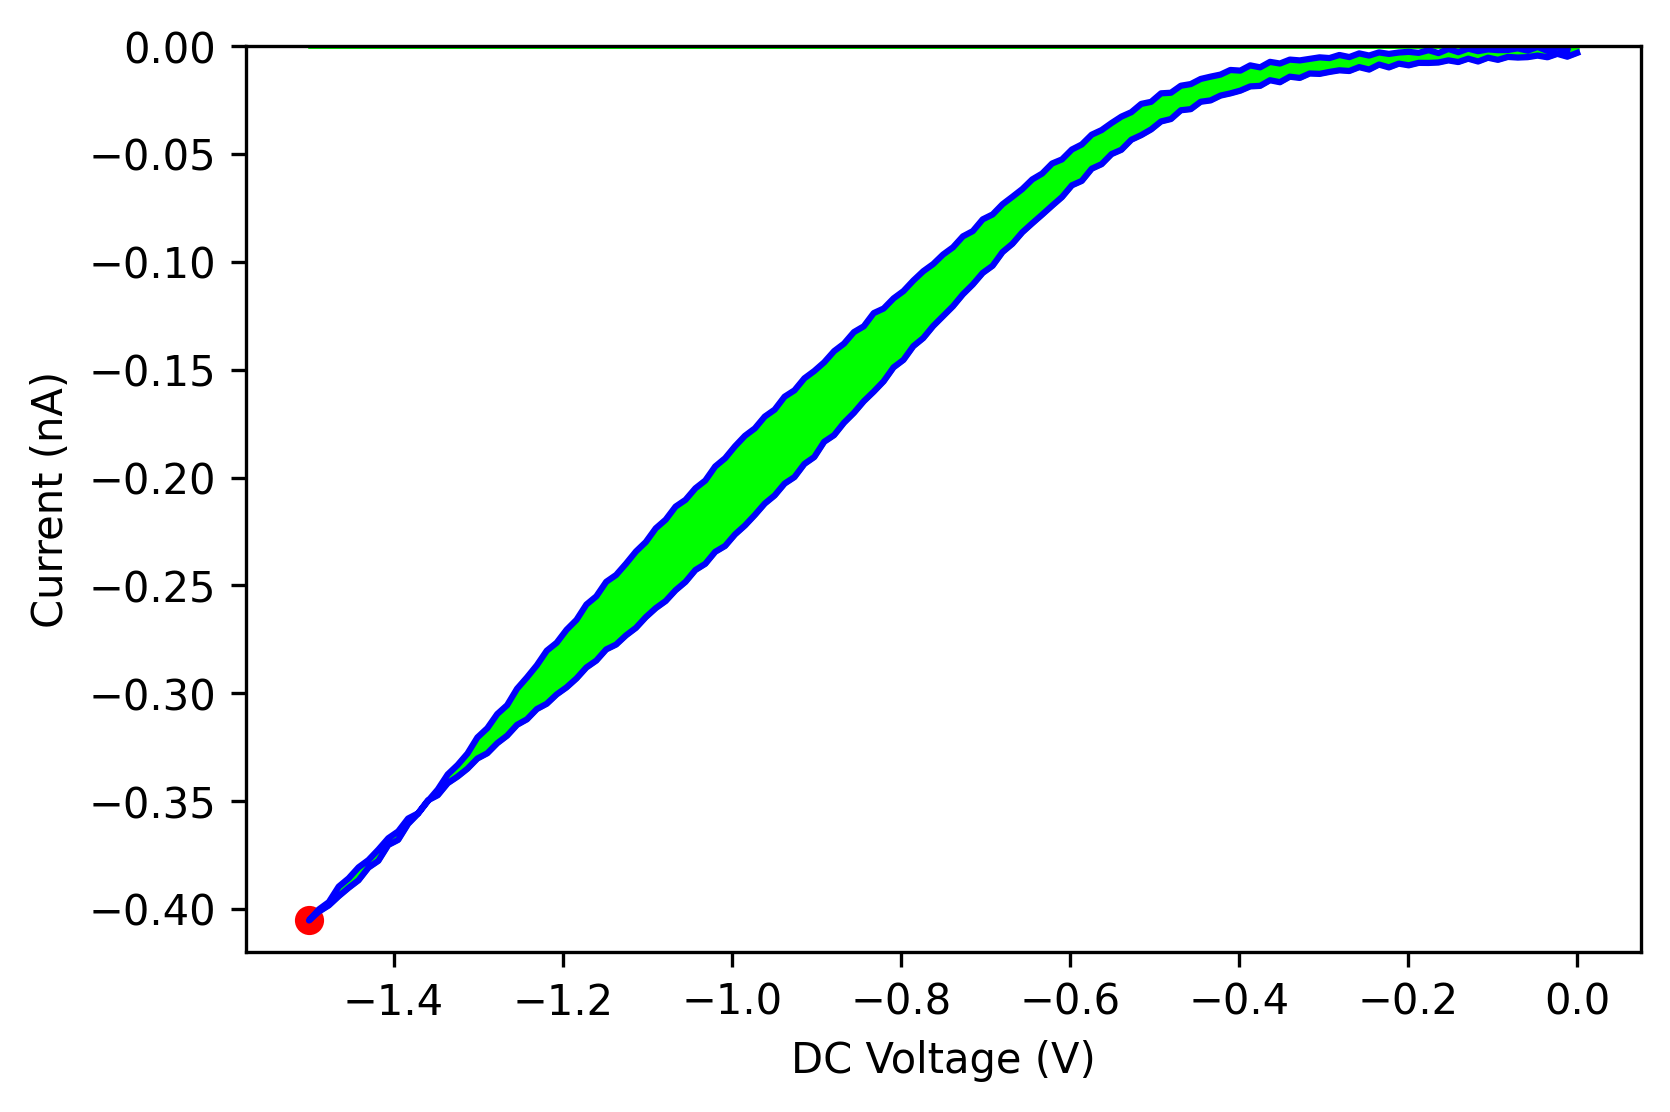

In [10]:
plt.figure(dpi = 300)
plt.plot(v_step, iv_light_gb.mean(0)*100, label = "Boundary + Light", c='blue')
plt.xlabel("DC Voltage (V)")
plt.ylabel("Current (nA)")
#plt.fill_between(v_step[:int(len(v_step)/2)], iv_light_gb.mean(0)[:int(len(v_step)/2)]*100, color = 'skyblue')
plt.fill_between(v_step, iv_light_gb.mean(0)*100, color = 'lime')
plt.scatter(v_step[128], iv_light_gb.mean(0)[128]*100, c = 'r')
plt.ylim(-0.42, -0)
#plt.legend()

In [11]:
turn_on_gb_light = np.zeros(len(gb_idx_x))
turn_on_gb_dark = np.zeros(len(gb_idx_x))
hys_gb_light = np.zeros(len(gb_idx_x))
hys_gb_dark = np.zeros(len(gb_idx_x))
area_gb_light = np.zeros(len(gb_idx_x))
area_gb_dark = np.zeros(len(gb_idx_x))

for i in range (len(gb_idx_x)):
  turn_on_gb_light[i] = turn_on_voltage(iv_light_gb[i,], v_step)
  turn_on_gb_dark[i] = turn_on_voltage(iv_dark_gb[i,], v_step)
  hys_gb_light[i] = hysteresis(iv_light_gb[i,])
  hys_gb_dark[i] = hysteresis(iv_dark_gb[i,])
  area_gb_light[i] = area_x(iv_light_gb[i,])
  area_gb_dark[i] = area_x(iv_dark_gb[i,])

(-0.5, 127.5, -0.5, 127.5)

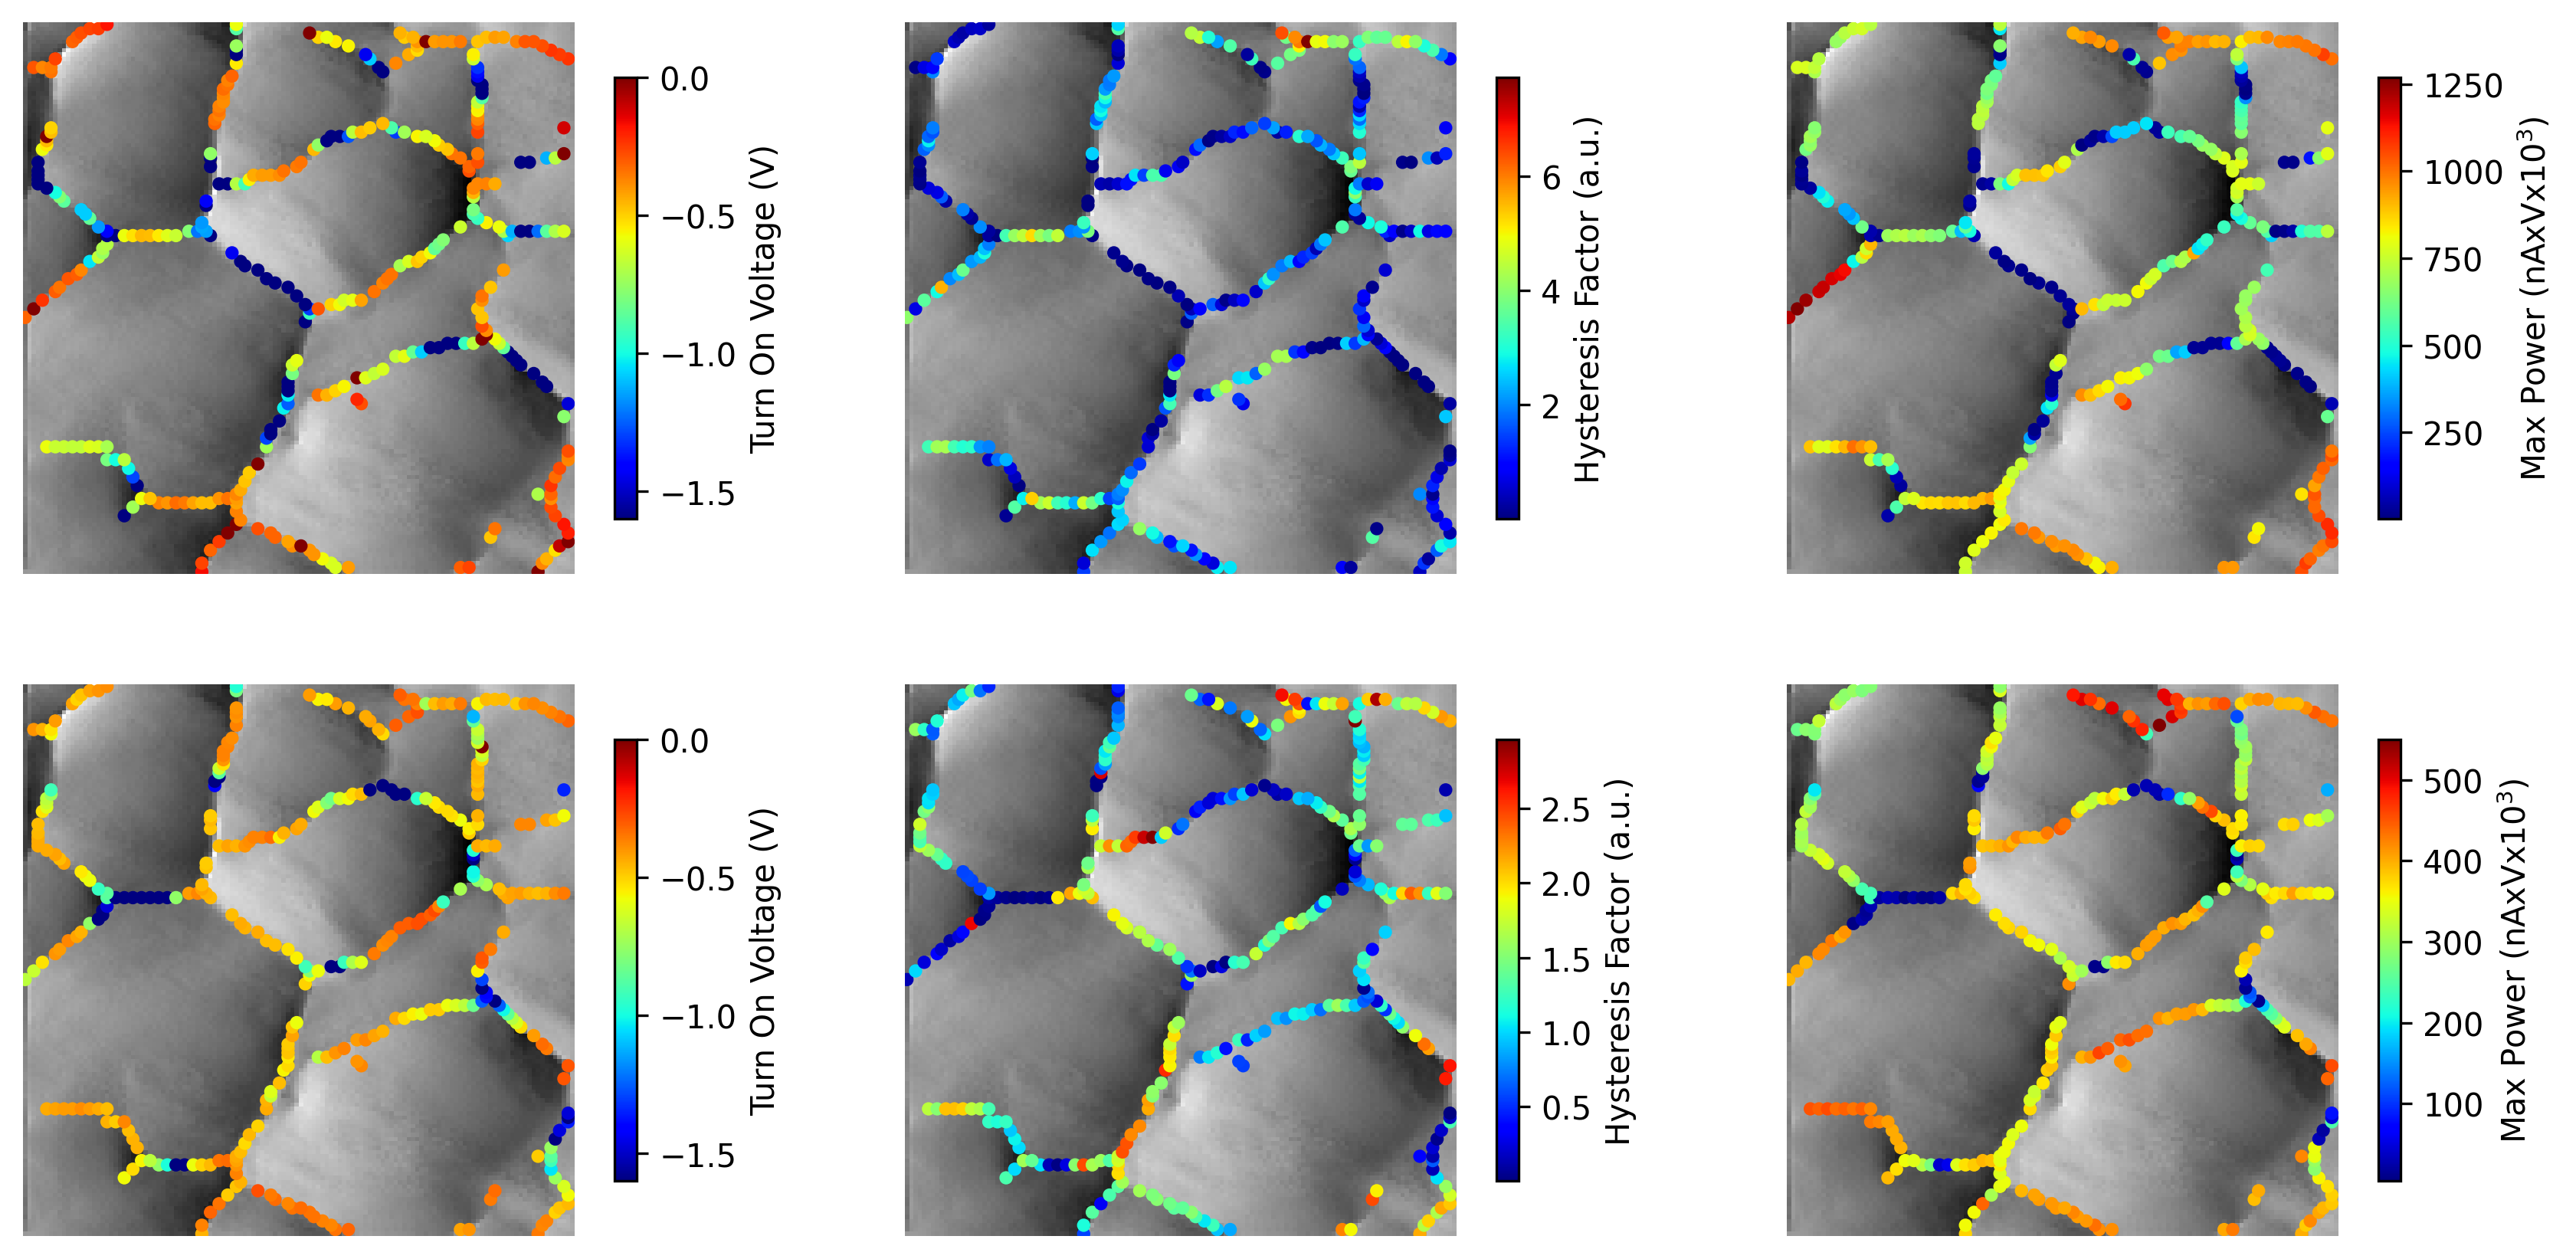

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), dpi = 300)
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.1)
# Make 4 subplots:
cm = 'viridis'
shrink = 0.8

im1 = axs[0, 0].scatter(gb_idx_x, gb_idx_y, s = 10, c=turn_on_gb_light, cmap='jet')
fig.colorbar(im1, ax=axs[0, 0], shrink = shrink, label = "Turn On Voltage (V)")
axs[0, 0].imshow(defl, origin = "lower", cmap='gray')
axs[0, 0].axis('off')

im2 = axs[1, 0].scatter(gb_idx_x, gb_idx_y, s = 10, c=turn_on_gb_dark, cmap='jet')
fig.colorbar(im2, ax=axs[1, 0], shrink = shrink, label = "Turn On Voltage (V)")
axs[1, 0].imshow(defl, origin = "lower", cmap='gray')
axs[1, 0].axis('off')

im3 = axs[0, 1].scatter(gb_idx_x, gb_idx_y, s = 10, c=hys_gb_light, cmap='jet')
fig.colorbar(im3, ax=axs[0, 1], shrink = shrink, label = "Hysteresis Factor (a.u.)")
axs[0, 1].imshow(defl, origin = "lower", cmap='gray')
axs[0, 1].axis('off')

im4 = axs[1, 1].scatter(gb_idx_x, gb_idx_y, s = 10, c=hys_gb_dark, cmap='jet')
fig.colorbar(im4, ax=axs[1, 1], shrink = shrink, label = "Hysteresis Factor (a.u.)")
axs[1, 1].imshow(defl, origin = "lower", cmap='gray')
axs[1, 1].axis('off')

im5 = axs[0, 2].scatter(gb_idx_x, gb_idx_y, s = 10, c=area_gb_light*1000, cmap='jet')
fig.colorbar(im5, ax=axs[0, 2], shrink = shrink, label = "Max Power (nAxVx10$^3$)")
axs[0, 2].imshow(defl, origin = "lower", cmap='gray')
axs[0, 2].axis('off')

im6 = axs[1, 2].scatter(gb_idx_x, gb_idx_y, s = 10, c=area_gb_dark*1000, cmap='jet')
fig.colorbar(im6, ax=axs[1, 2], shrink = shrink, label = "Max Power (nAxVx10$^3$)")
axs[1, 2].imshow(defl, origin = "lower", cmap='gray')
axs[1, 2].axis('off')

In [13]:
turn_on_grain_light = np.zeros(len(grain_idx_x))
turn_on_grain_dark = np.zeros(len(grain_idx_x))
hys_grain_light = np.zeros(len(grain_idx_x))
hys_grain_dark = np.zeros(len(grain_idx_x))
area_grain_light = np.zeros(len(grain_idx_x))
area_grain_dark = np.zeros(len(grain_idx_x))

for i in range (len(grain_idx_x)):
  turn_on_grain_light[i] = turn_on_voltage(iv_light_grain[i,], v_step)
  turn_on_grain_dark[i] = turn_on_voltage(iv_dark_grain[i,], v_step)
  hys_grain_light[i] = hysteresis(iv_light_grain[i,])
  hys_grain_dark[i] = hysteresis(iv_dark_grain[i,])
  area_grain_light[i] = area_x(iv_light_grain[i,])
  area_grain_dark[i] = area_x(iv_dark_grain[i,])

(-0.5, 127.5, -0.5, 127.5)

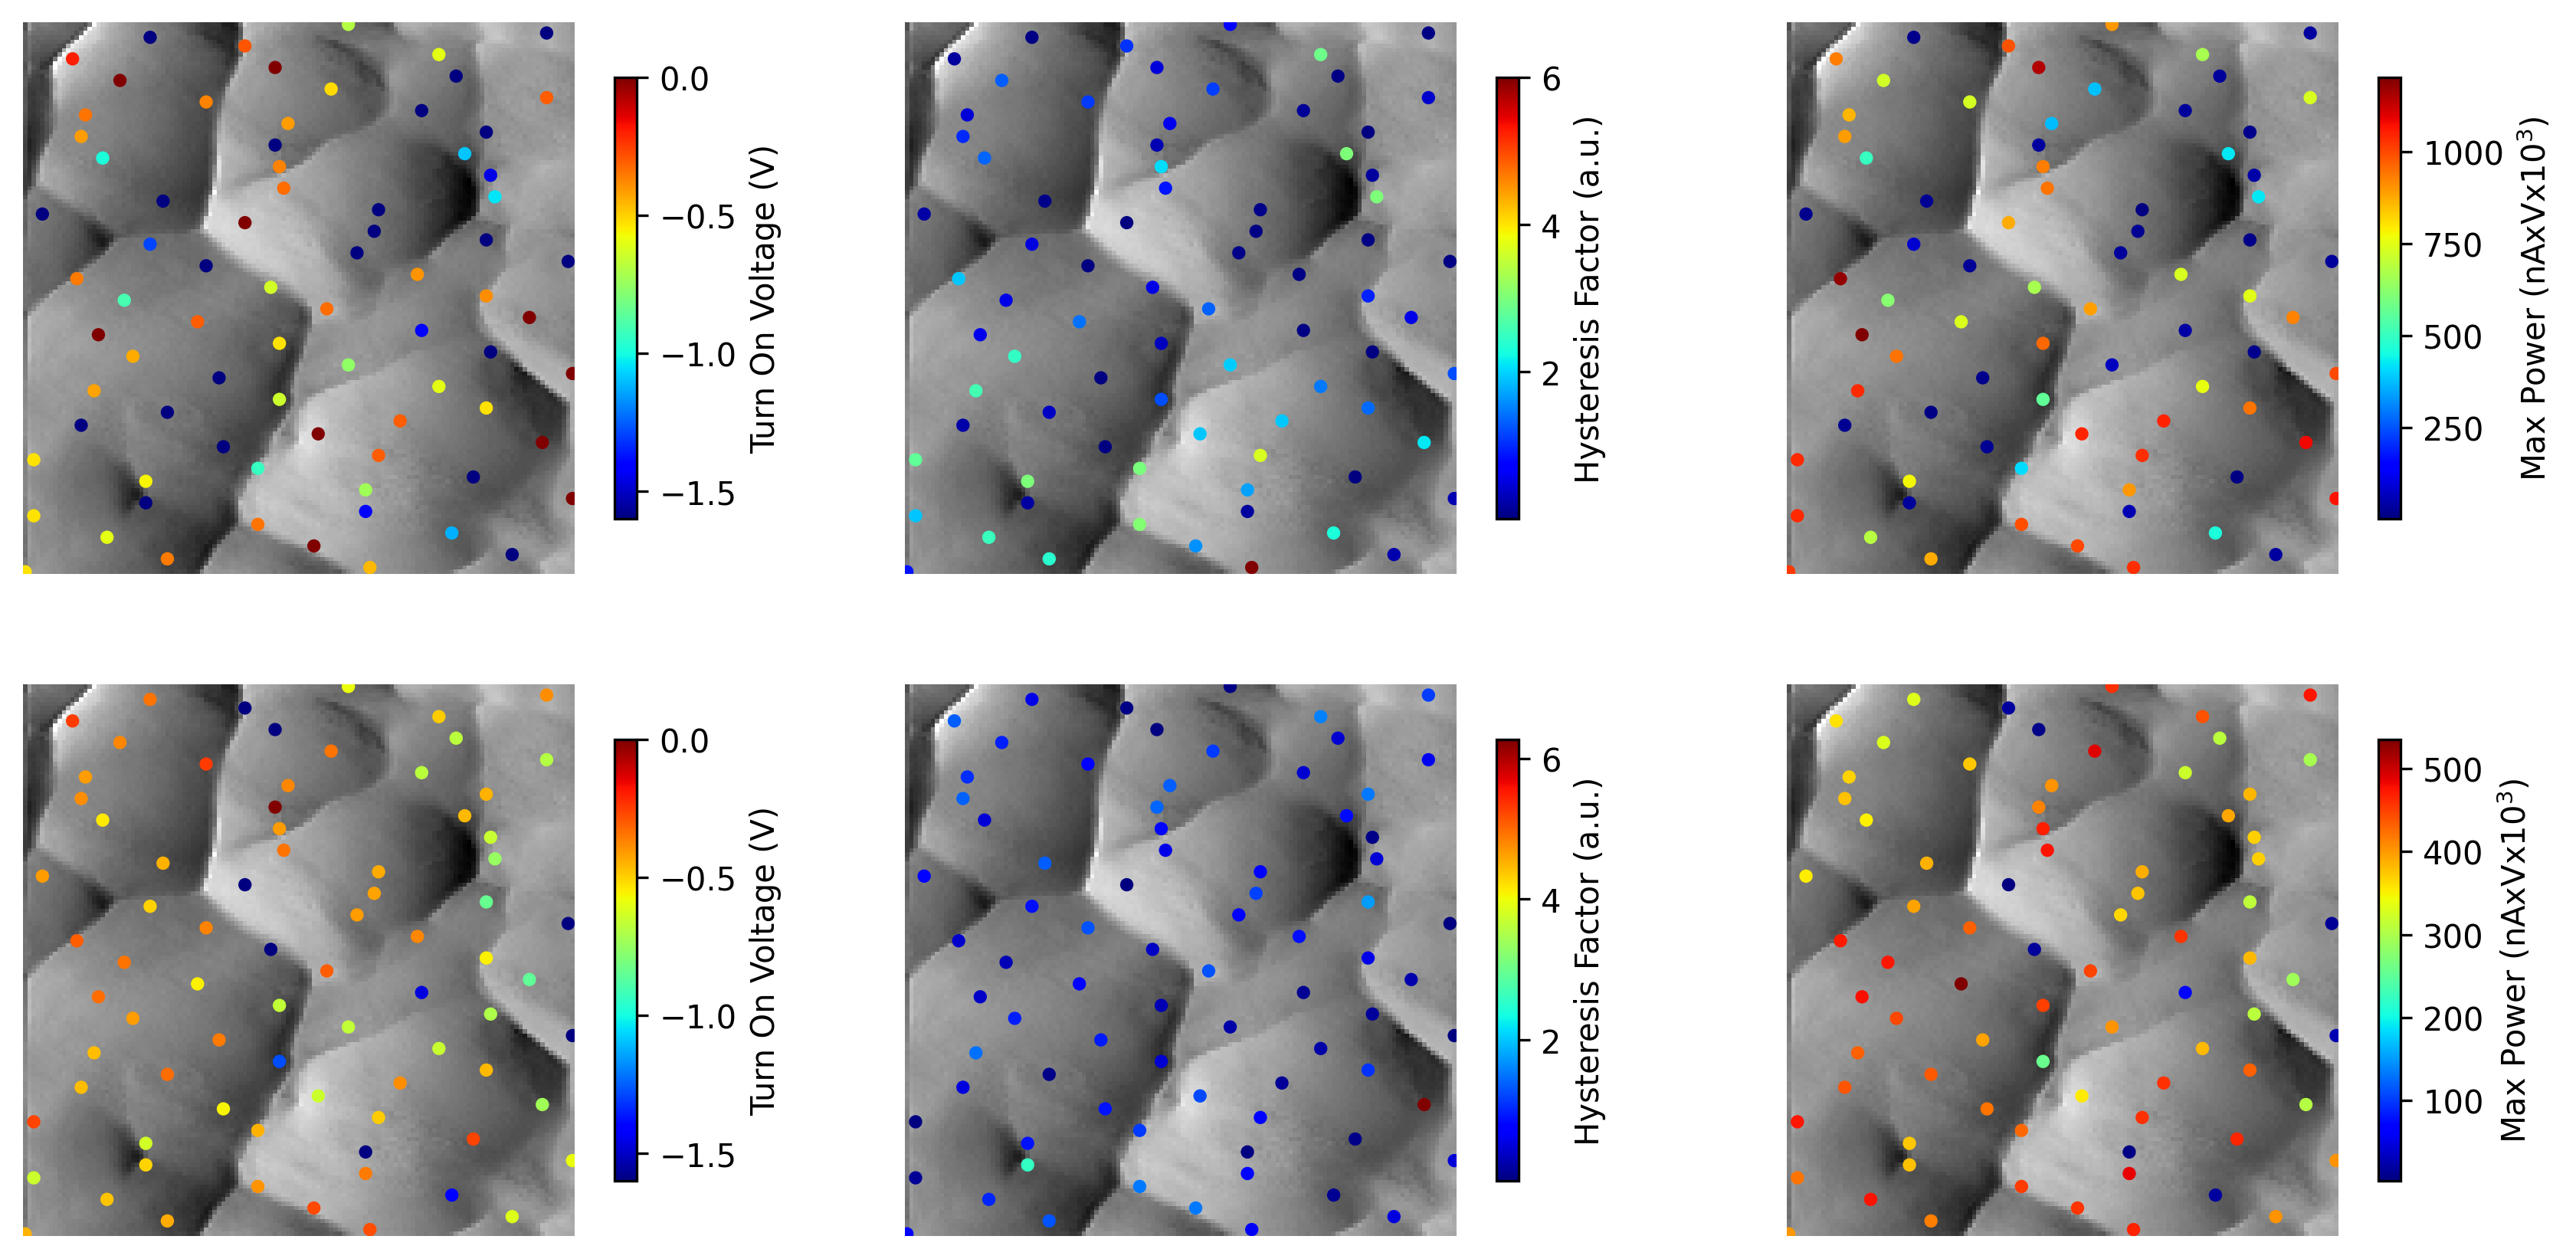

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), dpi =300)
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.1)
# Make 4 subplots:
cm = 'viridis'
shrink = 0.8

im1 = axs[0, 0].scatter(grain_idx_x, grain_idx_y, s = 10, c=turn_on_grain_light, cmap='jet')
fig.colorbar(im1, ax=axs[0, 0], shrink = shrink, label = "Turn On Voltage (V)")
axs[0, 0].imshow(defl, origin = "lower", cmap='gray')
axs[0, 0].axis('off')

im2 = axs[1, 0].scatter(grain_idx_x, grain_idx_y, s = 10, c=turn_on_grain_dark, cmap='jet')
fig.colorbar(im2, ax=axs[1, 0], shrink = shrink, label = "Turn On Voltage (V)")
axs[1, 0].imshow(defl, origin = "lower", cmap='gray')
axs[1, 0].axis('off')

im3 = axs[0, 1].scatter(grain_idx_x, grain_idx_y, s = 10, c=hys_grain_light, cmap='jet')
fig.colorbar(im3, ax=axs[0, 1], shrink = shrink, label = "Hysteresis Factor (a.u.)")
axs[0, 1].imshow(defl, origin = "lower", cmap='gray')
axs[0, 1].axis('off')

im4 = axs[1, 1].scatter(grain_idx_x, grain_idx_y, s = 10, c=hys_grain_dark, cmap='jet')
fig.colorbar(im4, ax=axs[1, 1], shrink = shrink, label = "Hysteresis Factor (a.u.)")
axs[1, 1].imshow(defl, origin = "lower", cmap='gray')
axs[1, 1].axis('off')

im5 = axs[0, 2].scatter(grain_idx_x, grain_idx_y, s = 10, c=area_grain_light*1000, cmap='jet')
fig.colorbar(im5, ax=axs[0, 2], shrink = shrink, label = "Max Power (nAxVx10$^3$)")
axs[0, 2].imshow(defl, origin = "lower", cmap='gray')
axs[0, 2].axis('off')

im6 = axs[1, 2].scatter(grain_idx_x, grain_idx_y, s = 10, c=area_grain_dark*1000, cmap='jet')
fig.colorbar(im6, ax=axs[1, 2], shrink = shrink, label = "Max Power (nAxVx10$^3$)")
axs[1, 2].imshow(defl, origin = "lower", cmap='gray')
axs[1, 2].axis('off')

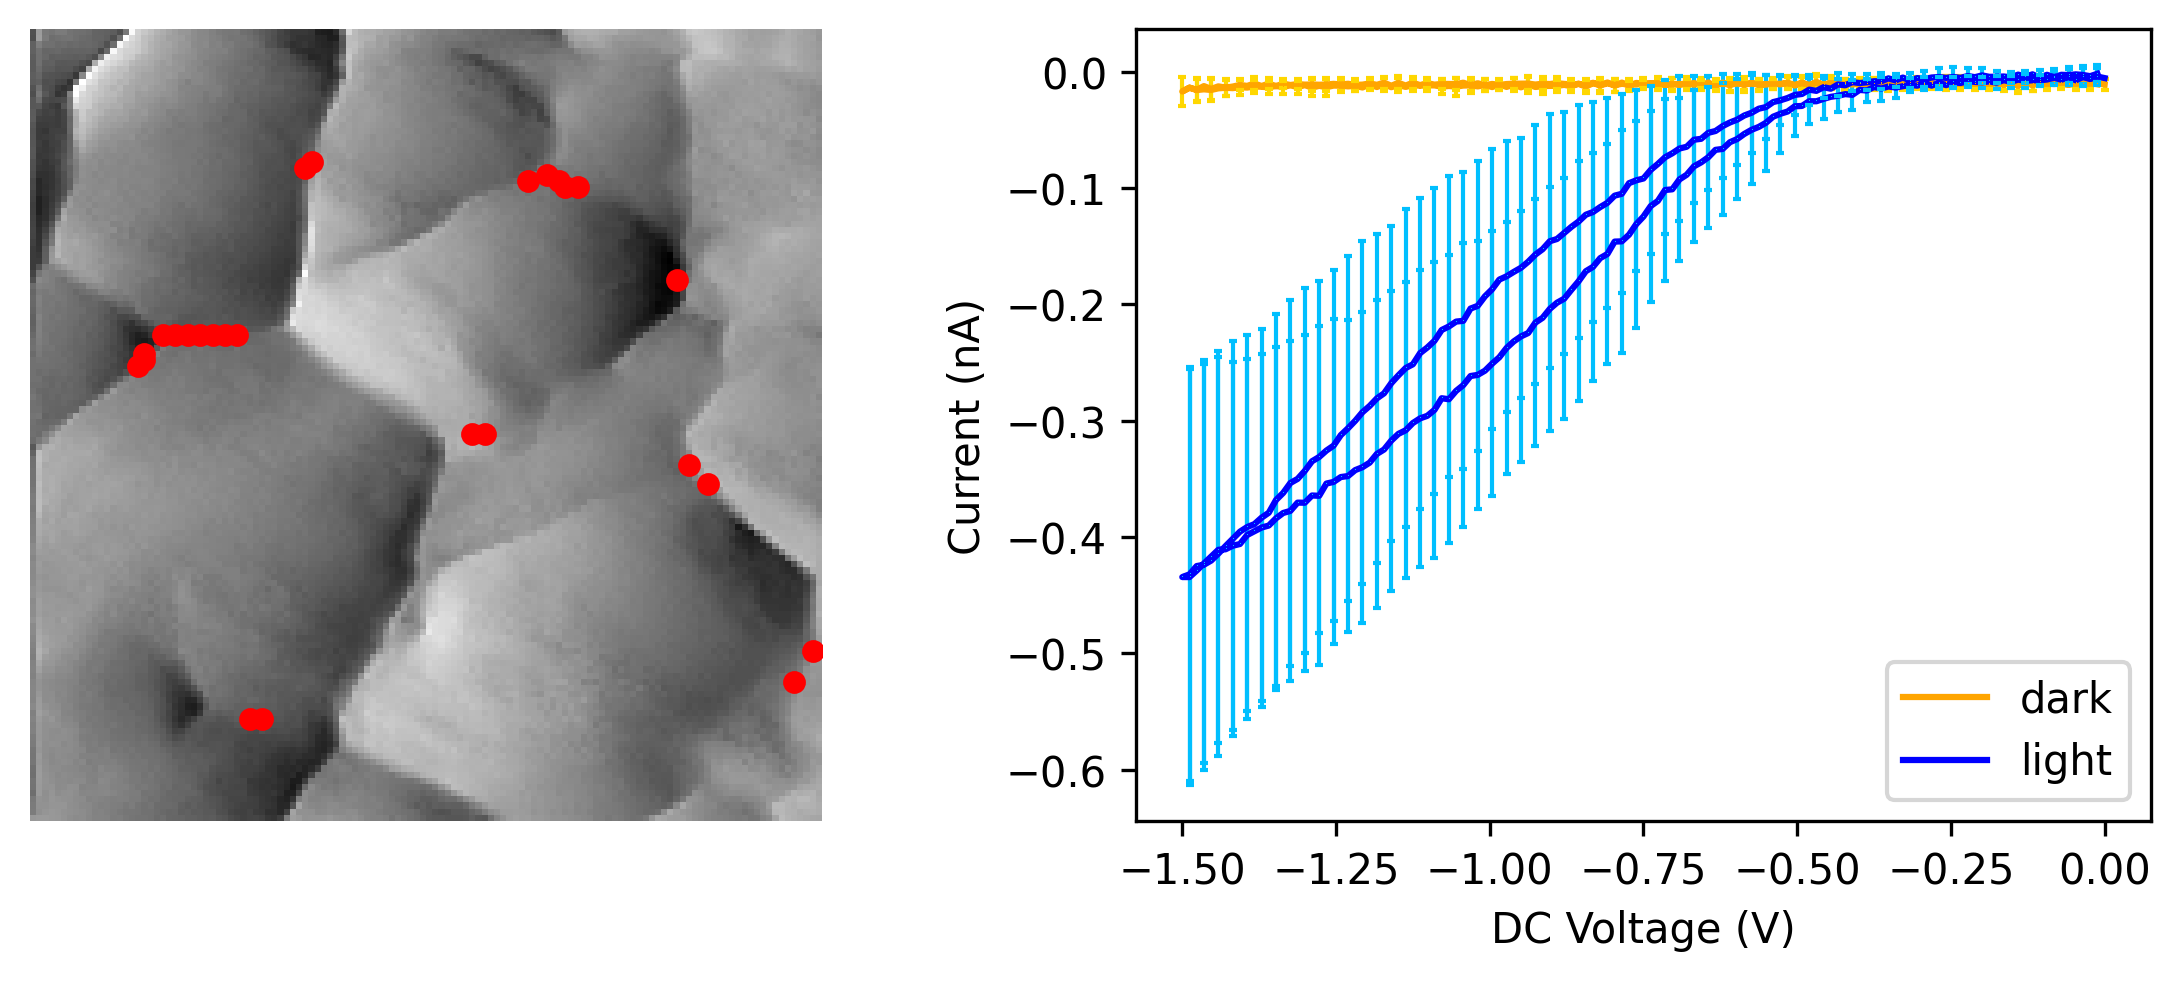

In [15]:
insu = np.where(turn_on_gb_dark==-1.6)[0]

fig, axs = plt.subplots(1, 2, figsize=(8, 3), dpi = 300)
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.2)
# Make 4 subplots:
cm = 'viridis'
shrink = 0.8

im1 = axs[0].scatter(gb_idx_x[insu], gb_idx_y[insu], s = 20, c='r')
#fig.colorbar(im1, ax=axs[0], shrink = shrink, label = "Turn On Voltage (V)")
axs[0].imshow(defl, origin = "lower", cmap='gray')
axs[0].axis('off')

axs[1].plot(v_step, iv_dark_gb[insu,].mean(0)*100, label = "dark", c = 'orange')
axs[1].errorbar(v_step,iv_dark_gb[insu,].mean(0)*100,yerr=np.std(iv_dark_gb[insu,]*100, axis=0),
             errorevery=2,fmt = ',',color = 'orange', 
             ecolor = 'gold', elinewidth = 1, capsize=1)

axs[1].plot(v_step, iv_light_gb[insu,].mean(0)*100, label = "light", c='blue')
axs[1].errorbar(v_step[1:],iv_light_gb[insu,1:].mean(0)*100,
             yerr=np.std(iv_light_gb[insu,1:]*100,axis=0),
             errorevery=2,fmt = ',',color = 'deepskyblue',
             ecolor = 'deepskyblue',elinewidth = 1,capsize=1)

axs[1].set_xlabel("DC Voltage (V)")
axs[1].set_ylabel("Current (nA)")
axs[1].legend()